# Comparaison inter-périodes
## Détection de changement de régime
>### Pourquoi réalise t-on une détection de changement de régime ?
Le but de la détection de changement de régime est d'identifier une rupture temporelle dans le comportement moyen de la SST. Notre série est longue temporellement, elle est désaisonnalisée donc on sait que les variations annuelles n'expliquent pas totalement la structure et la tendance n'est pas simplement linéaire ainsi une détection de changement de régime est pertinent ici.
>### Comment réalise t-on cette détection ?
La détection de changement de régime ne repose pas sur une simple formule, il s'agit d'une propriété statistique. Dans notre cas on calculera la moyenne glissante sur une période annuelle afin d'avoir un filtre de bruit de haute fréquence et de mettre en évidence le niveau moyen local. Puis on calculera la somme cumulée des anomalies centrées afin de trouver son minimum qui correspond à la date de rupture de régime.

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import xarray as xr

datasetDesaisonnalise = xr.open_dataset("../../data/processed/sstDeseasonalizedCOPERNICUS20102019.nc")
sstDesaisonnalise = datasetDesaisonnalise["analysed_sst"]

<xarray.DataArray 'analysed_sst' (time: 3652)> Size: 15kB
array([-0.17319854, -0.1576299 , -0.23866722, ..., -0.71061105,
       -0.70996517, -0.80401134], shape=(3652,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
    month    (time) int64 29kB ...
Attributes:
    units:          degC
    standard_name:  sea_surface_temperature
    long_name:      Analysed sea and under-ice surface temperature
    comment:        The under-ice SST is the freezing point temperature TS, c...
    source:         AASTI v2 SST/IST, ESA CCI SST and C3S SST L2P products
    valid_range:    [-6000  4500]


c:\Users\gaoks\Isen\ProjetM1\m1Project_SciML\venv\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


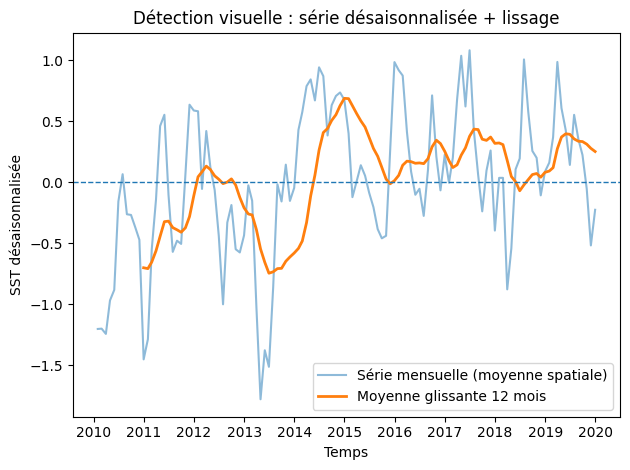

In [ ]:
spatialMean = sstDesaisonnalise.mean(dim=("latitude","longitude"))
print(spatialMean)

spatialMeanMonth = spatialMean.resample(time="1M").mean()
spatialMeanRolling = spatialMeanMonth.rolling(time=12).mean()

plt.plot(spatialMeanMonth["time"], spatialMeanMonth, label="Série mensuelle (moyenne spatiale)", alpha=0.5)
plt.plot(spatialMeanRolling["time"], spatialMeanRolling, label="Moyenne glissante 12 mois", linewidth=2)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Série mensuelle désaisonnalisée")
plt.xlabel("Temps")
plt.ylabel("SST désaisonnalisée")
plt.legend()
plt.tight_layout()
plt.show()

>### Comment interpréter nos résultats ?
La série temporelle de SST désaisonnalisée moyennée spatialement met en évidence une variabilité importante pour chaque mois ce qui représente les changements naturels de la Manche.
La moyenne glissante permet de voir deux phases distinctes à partir de l'instant où elle passe de majoritairement négative majoritairement positive, dans notre cas on peut voir qu'il s'agit de l'année 2014. Ce changement de niveau est persistant et ne correspond pas à une fluctuation ponctuelle.
Pour conclure cette courbe nous permet de suggérer l'existence d'un changement de régime temporel dans l'année 2014 marqué par une transition entre deux états de la SST désaisonnalisée.


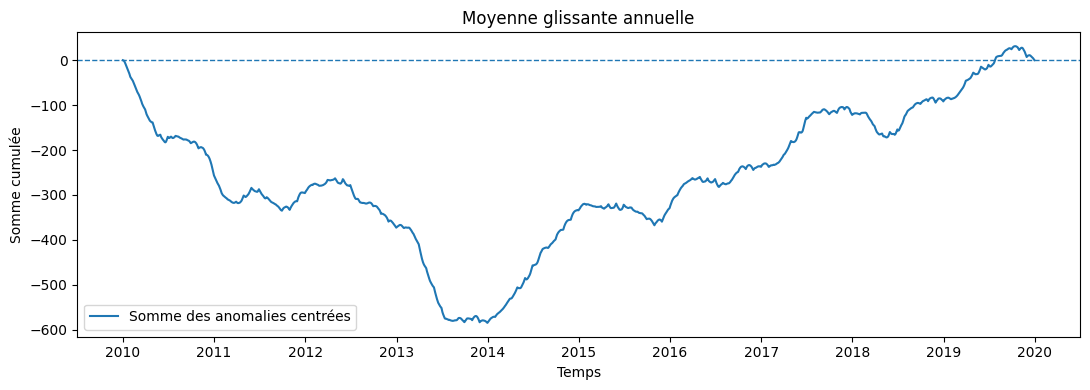

In [ ]:
centralisedMean = spatialMean - spatialMean.mean()

cumulMean = centralisedMean.cumsum()

plt.figure(figsize=(11,4))
plt.plot(cumulMean["time"], cumulMean, label="Somme des anomalies centrées")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Somme cumulée des anomalies centrées")
plt.xlabel("Temps")
plt.ylabel("Somme cumulée")
plt.legend()
plt.tight_layout()
plt.show()


>### Comment interpréter nos résultats ?
La courbe de somme des anomalies centrées agit comme une vérification pour analyser les changements de régime du niveau moyen. En effet on peut observer un changement de pente de la courbe à l'année 2014 (décroissante avant puis croissante ensuite) ce qui traduit une modification durable du régime moyen, il s'agit également du minimum de notre courbe correspondat à un point d'inflexion de la courbe. 
>### Que conclure de la détection de changement de période ?
La cohérence entre l'analyse par moyenne glissante et l'étude de la somme cumulée permet d'identifier de manière robuste un changement de régime autour de l'année 2014 qui sera notre date de définition pour nos deux périodes dinstinctes.

In [ ]:
breakDate = np.datetime64("2014-01-01")

beforeBreakPoint = spatialMeanMonth.sel(time=spatialMeanMonth.time < breakDate)
afterBreakPoint  = spatialMeanMonth.sel(time=spatialMeanMonth.time >= breakDate)

print("Avant rupture :")
print("  période :", str(beforeBreakPoint.time.values[0])[:10], "→", str(beforeBreakPoint.time.values[-1])[:10])
print("  moyenne :", float(beforeBreakPoint.mean()))

print("\nAprès rupture :")
print("  période :", str(afterBreakPoint.time.values[0])[:10], "→", str(afterBreakPoint.time.values[-1])[:10])
print("  moyenne :", float(afterBreakPoint.mean()))


Avant rupture :
  période : 2010-01-31 → 2013-12-31
  moyenne : -0.4009333550930023

Après rupture :
  période : 2014-01-31 → 2019-12-31
  moyenne : 0.2668832540512085


>### Quelle est la différence avant et après 2014 ?
La moyenne avant rupture est d'environ -0.40 ce qui signifie que les anomalies négatives sont dominantes, la SST est en moyenne inférieure à la moyenne globale de la période. Ainsi le système oscille autour d'un état plus "froid".
La moyenne après rupture est d'environ 0.27 donc les anomalies positives sont majoritaires et le système est centré sur un état moyen plus "chaud".

## Tests statistiques 
>### Quels test statistiques réalise t-on ?
Suite à la détection de rupture temporelle on remarque deux échantillons indépendants, issus d'une même variable et on veut comparer leur niveau moyen et leur comportement global.
Pour tester une différence de moyenne on peut utiliser le t-test qui pose comme hypothèse nulle :
$$
H_{0} : \mu_{avant} = \mu_{après}
$$
Ce qui est cohérent ici puisque nos échantillons sont grands et issus de séries lisées mensuelles.
Pour tester une différence de fonctions de répartition on peut utiliser le test KS qui est pertinent ici puisqu'on ne sait pas à l'avance si seule la moyenne change ou si la dispersion ou l'asymétrie changent également.
Pour conclure afin de pouvor comparer le niveau moyen et le comportement global de nos deux échantillons on fera deux tests : le t-test et le test KS.

In [15]:
from scipy.stats import ttest_ind

beforeValues = beforeBreakPoint.values.flatten()
afterValues  = afterBreakPoint.values.flatten()

tStat, pValue = ttest_ind(
    beforeValues,
    afterValues,
    equal_var=False,
    nan_policy="omit"
)

print("t-statistique :", tStat)
print("p-value :", pValue)


t-statistique : -6.5881314
p-value : 4.358314e-09


>### Comment interpréter nos résultats ?
On obtient une t-statistique de $-6.59$ et une p-value environ égale à $4.4 \times 10^{-9}$. 
Ces valeurs indique que la probabilité d'observer une telle différence de moyenne sous l'hypothèse d'égalité des moyennes est négligeable. Ainsi on peut rejeter l'hypothèse nulle et conclure à une augmentation significative du niveau moyen des anomalies de SST après 2014.

In [16]:
from scipy.stats import ks_2samp

ksStat, ksPvalue = ks_2samp(
    beforeValues,
    afterValues
)

print("KS statistique :", ksStat)
print("p-value KS :", ksPvalue)


KS statistique : 0.5416666666666666
p-value KS : 3.175470509559999e-08


>### Comment interpréter nos résultats ?
Le test de Kolmogorov-Smirnov confirme également l'existence de différences significatives entre les deux régimes temporels. La statistique KS de $0.54$ comparée à la p-value de $3.17 \times 10^{-8}$ est très élevée ce qui montre une différence de distribution des anomalies de SST avant et après 2014.
Contrairement au test t qui se concentre uniquement sur la moyenne le test KS prend en compte la distribution des valeurs. Le résultat obtenu montre que le changement observé n'est pas un simple décalage du niveau moyen mais affecte globalement le comportement statistique de la série.

## Boxplots comparatifs des régimes
>### Pourquoi réalise t-on des boxplots ?
Les boxplots permettent de résumer visiuellement la distribution par la médiane, les quartiles, la dispersion et les valeurs extrêmes. Ainsi on s'en sert ici pour illuster la différence de moyenne du t-test et visualiser la différence de distribution du test KS.

C:\Users\gaoks\AppData\Local\Temp\ipykernel_27208\820791502.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


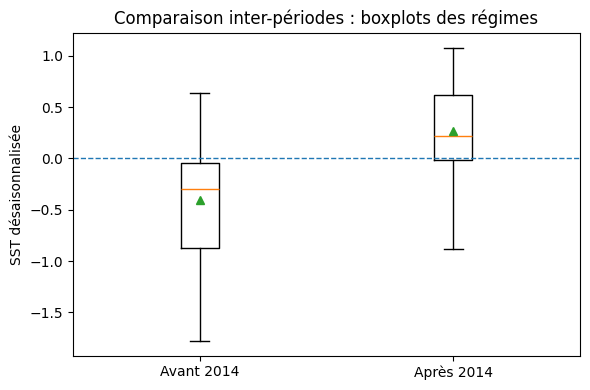

In [17]:
plt.figure(figsize=(6,4))
plt.boxplot(
    [beforeValues, afterValues],
    labels=["Avant 2014", "Après 2014"],
    showmeans=True
)

plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel("SST désaisonnalisée")
plt.title("Comparaison inter-périodes : boxplots des régimes")
plt.tight_layout()
plt.show()

>### Comment exploiter nos résultats ?
Les boxplots comparatifs des anomalies de SST désaisonnalisée avant et après 2014 mettent en évidence la différnece marquée entre les deux régimes temporels. La période avant est marquée par des valeurs négatives et une moyenne inférieure à zéro ce qui montre une dominance d'anomalies négatives. A l'inverse la période post 2014 présente une distribution décalée vers les valeurs positives avec une médiane et une moyenne supérieure à zéro.
Le décalage des deux boîtes permettent de confirmer visuellement que les anomalies de SST ne suivent pas le même régime statistique sur l'ensemble de la période étudiée.
Pour finir ces résultats sont en accord avec les conclusions des tests statistiques qui mettent en évidence une différence significative des moyennes et des distributions entre les deux périodes.